## Dataset Import

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zzettrkalpakbal/full-filled-brain-stroke-dataset")


100%|██████████| 52.1k/52.1k [00:00<00:00, 1.15MB/s]

Extracting files...


### Importing Libaries

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [14]:
df = pd.read_csv("full_data.csv")

In [15]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [16]:
df.shape

(4981, 11)

In [17]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [18]:
df.loc[df.duplicated()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


AttributeError: Line2D.set() got an unexpected keyword argument 'type'

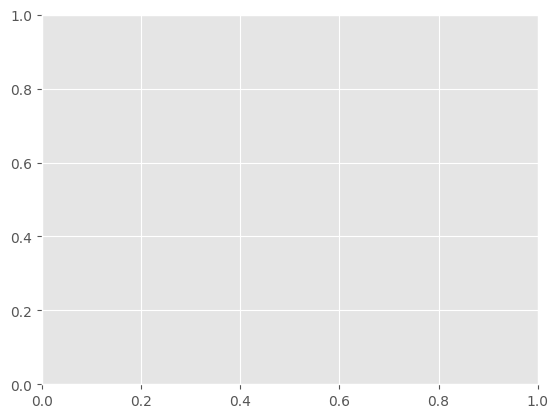

In [19]:
df.plot()